In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

** Reading in the file into a Pandas DataFrame and plotting the target variable **

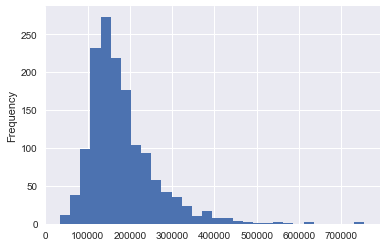

In [2]:
df = pd.read_csv("train.csv")
df.SalePrice.plot.hist(bins=30)

### Dealing with outliers

We notice that there are some outliers in our dataset with very high prices and very low prices. 
We also notice that our data is skewed to the right.

This may affect our model if we leave the outliers in out dataset.

In [3]:
#Counting outliers
lower_bound = 50000
upper_bound = 400000
upper_out = df.loc[df.SalePrice > upper_bound].Id.count()
lower_out = df.loc[df.SalePrice < lower_bound].Id.count()

print(upper_out,lower_out,df.shape)

28 5 (1460, 81)


The identified outliers which we have roughly choosen makes up 2% of our training data, so removing it would not affect our model significantly in terms of the number of examples to train on.

Lets remove the outliers and plot the target variable.

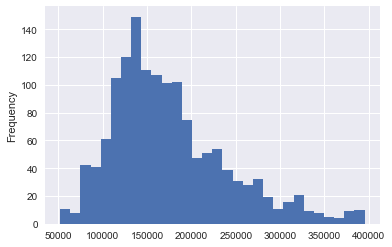

In [4]:
#Create a new dataframe with outliers removed
df1 = df.loc[(df.SalePrice > lower_bound) & (df.SalePrice < upper_bound) ]
df1.shape

df1.SalePrice.plot.hist(bins=30)

Now the target variable does look more normally distributed, but is still skewed to the right.
At this point, we could do a transformation to ensure that the target variable is more close to being normally distributed, but we will leave this out for now.

### Sparse Variables

Now let's look for variables that have many missing values. These variables will probably not be very useful when we use our learning algorithms to build the Model.

Note that now we would need to combine our training and test datasets, as we cannot have different variables in these datasets.

In [5]:
#Merging the train and test datasets - Note that price variable will be missing on the test dataset
_df = pd.read_csv('test.csv')
dfmerged = pd.concat([df1,_df]).set_index('Id')
dfmerged.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


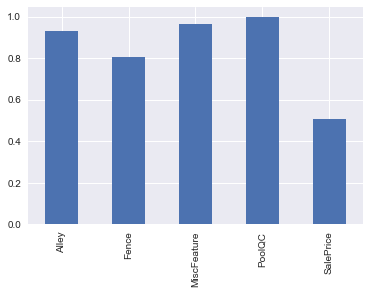

In [6]:
#Number of observations
n = dfmerged.shape[0]

#% of Missing Values
_missing = pd.DataFrame(dfmerged.isnull().sum())
_missing['Count'] = n
_missing['%Miss'] = _missing[0] / _missing.Count
_missing.loc[_missing['%Miss'] > 0.5]['%Miss'].plot.bar()

As from the above we can see that there are a number of columns that have large number of missing values. We can remove them.

In [7]:
col_rem = _missing.loc[_missing['%Miss'] > 0.5]['%Miss'].index[0:-1]
df

#removing variables exlcuding sale price
dfmerged.drop(col_rem, axis = 1, inplace = True)
dfmerged.shape

(2886, 76)

### Missing Values

Lets now investigate missing values. We have a few ways that we can address missing values. 
It is important to understand if the missing values has meaning - that is if there are reasons why they are missing that might help the model learn better.

In [8]:
missing_val = dfmerged.isnull().sum()
missing_val = missing_val[missing_val > 0]
missing_val

BsmtCond          81
BsmtExposure      81
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      78
BsmtFinType2      79
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          80
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
FireplaceQu     1415
Functional         2
GarageArea         1
GarageCars         1
GarageCond       156
GarageFinish     156
GarageQual       156
GarageType       154
GarageYrBlt      156
KitchenQual        1
LotFrontage      484
MSZoning           4
MasVnrArea        22
MasVnrType        23
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

Let's look into detail at missing values starting at Lot Area

In [9]:
#Type of Lots where LotFrontage is missing
dfmerged.loc[dfmerged.LotFrontage.isnull()].LotConfig.value_counts()

Inside     269
Corner     104
CulDSac     87
FR2         20
FR3          4
Name: LotConfig, dtype: int64

In [10]:
dfmerged.corr().LotFrontage[dfmerged.corr().LotFrontage>0.3]

1stFlrSF        0.452124
GarageArea      0.352974
GarageCars      0.300778
GrLivArea       0.371851
LotArea         0.502170
LotFrontage     1.000000
SalePrice       0.331818
TotRmsAbvGrd    0.341704
TotalBsmtSF     0.344550
Name: LotFrontage, dtype: float64

We can see in the above that LotFrontage is highly correlated to LotArea, which is reasonable to expect.

Therefore one reasonable treatment we can apply to the missing values is to use use the ratio of LotFrontage to LotArea to infer a value

In [11]:
def LotRatio(df):
    df['LotRatio'] = df.LotFrontage / df.LotArea
    return df


_lotfrontage = dfmerged.apply(LotRatio,axis='columns').groupby('LotConfig').LotRatio.mean()
_lotfrontage

#Now we can use this ratio to calculate LotFrontage from LotArea
LotFrontReplace = [(_lotfrontage.index[i],_lotfrontage[i]) for i in range(len(_lotfrontage))]
LotFrontReplace

def LotReplace(df):
    for i in range(len(LotFrontReplace)):
        if np.isnan(df.LotFrontage) and df.LotConfig == LotFrontReplace[i][0]:
            df['LotFrontage'] = LotFrontReplace[i][1] * df.LotArea
    return df

df2 = dfmerged.apply(LotReplace, axis='columns')
df2.shape


(2886, 76)

Now lets take garages - There is a null value if there is no garage, and we can replace this category.

However, garage area and garage cars does not have the same number of null values...

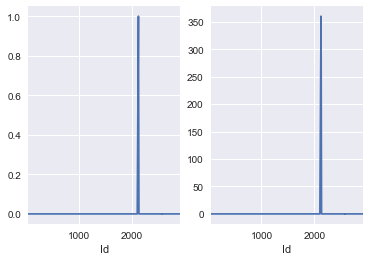

In [12]:
fig, axs = plt.subplots(1,2)
df2[(df2.GarageCond.isnull() == True)].GarageCars.plot(ax=axs[0])
df2[(df2.GarageCond.isnull() == True)].GarageArea.plot(ax=axs[1])

Garage Area and Care variable set to 0 value if no garage. However, we have house with No GarageCondition, but does appear to have a garage

In [13]:
df2[(df2.GarageCond.isnull() == True) & (df2.GarageArea > 1)][['GarageArea','GarageType','GarageCond','GarageFinish','GarageQual','GarageYrBlt']]

,GarageArea,GarageType,GarageCond,GarageFinish,GarageQual,GarageYrBlt
Id,,,,,,
2127,360.0,Detchd,NaN,NaN,NaN,NaN


Where GarageArea and GarageCars = 0, we can set the Garage Categorical Variables to "No Garage"

In [14]:
def GarageReplace(df):
    if df.GarageArea == 0 and df.GarageCars == 0:
        df["GarageType"] = "No Garage"
        df["GarageCond"] = "No Garage"
        df["GarageFinish"] = "No Garage"
        df["GarageQual"] = "No Garage"
        df["GarageYrBlt"] = -1

    return df

df3 = df2.apply(GarageReplace,axis='columns')
    

In [15]:
df3.isnull().sum()[df3.isnull().sum() > 0]

BsmtCond          81
BsmtExposure      81
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      78
BsmtFinType2      79
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          80
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
FireplaceQu     1415
Functional         2
GarageArea         1
GarageCars         1
GarageCond         2
GarageFinish       2
GarageQual         2
GarageYrBlt        2
KitchenQual        1
MSZoning           4
MasVnrArea        22
MasVnrType        23
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [16]:
df3[df3.GarageArea.isnull()][['GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']]

,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
Id,,,,,,
2577,NaN,NaN,NaN,NaN,Detchd,NaN


In the data description, the value of NA with respects to a Garage means that there is no garage.

Using this logic, it is possible that this was a mistake and the house does not have a garage

In [17]:
def GarageError(df):
    if np.isnan(df.GarageCars) == True:
        df["GarageType"] = "No Garage"
        df["GarageCond"] = "No Garage"
        df["GarageFinish"] = "No Garage"
        df["GarageQual"] = "No Garage"
        df["GarageYrBlt"] = -1
        df["GarageCars"] = 0
        df["GarageArea"] = 0
    return df

df3 = df3.apply(GarageError,axis='columns')
        
        

In [18]:
df3.isnull().sum()[df3.isnull().sum() > 0]

BsmtCond          81
BsmtExposure      81
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      78
BsmtFinType2      79
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          80
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
FireplaceQu     1415
Functional         2
GarageCond         1
GarageFinish       1
GarageQual         1
GarageYrBlt        1
KitchenQual        1
MSZoning           4
MasVnrArea        22
MasVnrType        23
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [19]:
df3[df3.GarageCond.isnull()][['GarageCars','GarageArea','GarageFinish','GarageQual','GarageType','GarageYrBlt','OverallCond','OverallQual','YearBuilt','YearRemodAdd']]

,GarageCars,GarageArea,GarageFinish,GarageQual,GarageType,GarageYrBlt,OverallCond,OverallQual,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
2127,1.0,360.0,NaN,NaN,Detchd,NaN,8,6,1910,1983


In the above case, the other attributes of the garage is missing, and we can see that overall the house is in good condition.

We therefore replace the Garage Quality attributes to 'Good' and set the Year Built to the remoddled date

In [20]:
def GarageError1(df):
    if pd.isnull(df.GarageCond) == True:
        df["GarageCond"] = "Gd"
        df["GarageFinish"] = "Fin"
        df["GarageQual"] = "Gd"
        df["GarageYrBlt"] = df.YearRemodAdd
    return df
df3 = df3.apply(GarageError1,axis='columns')

In [21]:
df3.isnull().sum()[df3.isnull().sum() > 0]

BsmtCond          81
BsmtExposure      81
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      78
BsmtFinType2      79
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          80
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
FireplaceQu     1415
Functional         2
KitchenQual        1
MSZoning           4
MasVnrArea        22
MasVnrType        23
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

Thats Great! - Now we have solved missing values related to the Garage.

Another area that we can work on is Basment variables and Fireplace quality. In the data description, we see that these values are set to NA if the house does not have a fireplace or basement

In [22]:
def BsmtFire(df):
    if pd.isnull(df.BsmtCond) == True and pd.isnull(df.BsmtQual) == True:
        df['BsmtCond'] = 'No Basement'
        df['BsmtQual'] = 'No Basement'
        df['BsmtExposure'] = 'No Basement'
        df['BsmtFinType1'] = 'No Basement'
        df['BsmtFinType2'] = 'No Basement'
        
    if pd.isnull(df.FireplaceQu ) == True:
        df['FireplaceQu'] = 'No Fireplace'
        
        
    return df

df3 = df3.apply(BsmtFire,axis='columns')

In [23]:
df3.isnull().sum()[df3.isnull().sum() > 0]

BsmtCond           3
BsmtExposure       3
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType2       1
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual           2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Functional         2
KitchenQual        1
MSZoning           4
MasVnrArea        22
MasVnrType        23
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [24]:
df3[df3.BsmtCond.isnull()][['BsmtQual','BsmtFinType1','BsmtFinType2',"OverallCond"]]

,BsmtQual,BsmtFinType1,BsmtFinType2,OverallCond
Id,,,,
2041,Gd,GLQ,Rec,9
2186,TA,BLQ,Unf,6
2525,TA,ALQ,Unf,7


Where basement condition is missing, we will assume that the condition is related to the overall condition of the house.

Therefore 6/7 will be typical basement condition while a 9 will be excellent condition.

In [25]:
def BmstCond(df):
    if pd.isnull(df.BsmtCond) == True:
        if df.OverallCond == 6 or df.OverallCond == 7:
            df['BsmtCond'] = 'TA'
        elif df.OverallCond == 9:
            df['BsmtCond'] = 'Ex'
    return df

df3 = df3.apply(BmstCond, axis = "columns")
            
            
            

In [26]:
df3[df3.BsmtExposure.isnull()][['BsmtCond','BsmtFinSF1','HouseStyle']]

,BsmtCond,BsmtFinSF1,HouseStyle
Id,,,
949,TA,0.0,2Story
1488,TA,0.0,1Story
2349,TA,0.0,2Story


In [27]:
df3.groupby('HouseStyle').BsmtExposure.value_counts()

HouseStyle  BsmtExposure
1.5Fin      No              265
            Mn               28
            No Basement       8
            Av                7
            Gd                4
1.5Unf      No               18
            Av                1
1Story      No              915
            Av              201
            Gd              158
            Mn              125
            No Basement      58
2.5Fin      No                7
2.5Unf      No               20
            Mn                4
2Story      No              629
            Av               91
            Mn               76
            Gd               47
            No Basement      10
SFoyer      Av               56
            Gd               25
            No                1
            No Basement       1
SLvl        Av               55
            No               39
            Gd               29
            Mn                4
            No Basement       1
Name: BsmtExposure, dtype: int64

Typically HouseStyle 1Story and 2 Story has basments with no exposure, therefore we shall replace the missing values for BsmtExposure variable to that.

In [28]:
df3['BsmtExposure'] = df3['BsmtExposure'].apply(lambda df: 'No' if pd.isnull(df) == True else df)

In [29]:
df3.isnull().sum()[df3.isnull().sum() > 0]

BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType2       1
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual           2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Functional         2
KitchenQual        1
MSZoning           4
MasVnrArea        22
MasVnrType        23
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

MSZone missing values - we can look at the building type for these missing values and the neighborhood that they reside in the infer a value for the zoning.

In the below we can see that they are all 1Fam homes and either will be RL or RM depending on the neighborhoold


In [30]:
df3[df3.MSZoning.isnull()].BldgType
df3[df3.MSZoning.isnull()].Neighborhood

Id
1916     IDOTRR
2217     IDOTRR
2251     IDOTRR
2905    Mitchel
Name: Neighborhood, dtype: object

In [31]:
df3.groupby('Neighborhood').MSZoning.value_counts()

Neighborhood  MSZoning
Blmngtn       RL           25
              RM            3
Blueste       RM           10
BrDale        RM           30
BrkSide       RM           65
              RL           42
ClearCr       RL           44
CollgCr       RL          252
              RM           14
Crawfor       RL           91
              RM           10
              RH            2
Edwards       RL          180
              RM           12
              RH            2
Gilbert       RL          165
IDOTRR        RM           68
              C (all)      19
MeadowV       RM           37
Mitchel       RL          104
              RM            9
NAmes         RL          436
              RH            7
NPkVill       RL           23
NWAmes        RL          131
NoRidge       RL           63
NridgHt       RL          152
              RM            1
OldTown       RM          196
              RL           39
              C (all)       2
SWISU         RL           38
              RH 

In [32]:
def MissingZone(df):
    if pd.isnull(df.MSZoning) == True:
        if df.Neighborhood == 'IDOTRR':
            df['MSZoning'] = 'RM'
        elif df.Neighborhood == 'Mitchel':
            df['MSZoning'] = 'RL'
    return df

df3 = df3.apply(MissingZone,axis='columns')
            
            
    
    

In [33]:
df3.isnull().sum()[df3.isnull().sum() > 0]

BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType2       1
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual           2
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Functional         2
KitchenQual        1
MasVnrArea        22
MasVnrType        23
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

In [34]:
df3[df3.BsmtFullBath.isnull()][['BsmtFinSF1','BsmtFinSF2','BsmtFinType2','BsmtFullBath','BsmtHalfBath','BsmtQual','BsmtUnfSF']]

,BsmtFinSF1,BsmtFinSF2,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
Id,,,,,,,
2121,NaN,NaN,No Basement,NaN,NaN,No Basement,NaN
2189,0.0,0.0,No Basement,NaN,NaN,No Basement,0.0


In [35]:
df3[df3.BsmtFinSF1.isnull()][['BsmtFinSF2','BsmtFinSF2','BsmtFinType2','BsmtFullBath','BsmtHalfBath','BsmtQual','BsmtUnfSF']]

,BsmtFinSF2,BsmtFinSF2,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
Id,,,,,,,
2121,NaN,NaN,No Basement,NaN,NaN,No Basement,NaN


In [36]:
df3[df3.BsmtQual.isnull()][['BsmtFinSF2','BsmtFinSF2','BsmtFinType2','BsmtFullBath','BsmtHalfBath','BsmtQual','BsmtUnfSF']]

,BsmtFinSF2,BsmtFinSF2,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
Id,,,,,,,
2218,0.0,0.0,Unf,0.0,0.0,NaN,173.0
2219,0.0,0.0,Unf,0.0,0.0,NaN,356.0


In [37]:
df3[df3.BsmtFinType2.isnull()][['BsmtFinSF2','BsmtFinSF2','BsmtQual','BsmtFullBath','BsmtHalfBath','BsmtQual','BsmtUnfSF','BsmtFinType1']]

,BsmtFinSF2,BsmtFinSF2,BsmtQual,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,BsmtFinType1
Id,,,,,,,,
333,479.0,479.0,Gd,1.0,0.0,Gd,1603.0,GLQ


It is clear from the above that those buildings do not have a basement, so therefore we can easily fix the missing values.

In [38]:
def BsmtFix(df):
    if pd.isnull(df.BsmtFullBath) == True or pd.isnull(df.BsmtFinSF1) == True:
        df['BsmtFinSF1'] = 0
        df['BsmtFinSF2'] = 0
        df['BsmtFullBath'] = 0
        df['BsmtHalfBath'] = 0
        df['BsmtQual'] = 'No Basement'
        df['BsmtUnfSF'] = 0
        
    if  pd.isnull(df.BsmtQual) == True:
        df['BsmtQual'] = 'No Basement'    
    
    #Set to the rating of the first basement type rating
    if pd.isnull(df.BsmtFinType2) == True:
        df['BsmtFinType2'] = df.BsmtFinType1
    
    return df

df3 = df3.apply(BsmtFix,axis='columns')
        
        
        
        

In [39]:
df3.isnull().sum()[df3.isnull().sum() > 0]

Electrical        1
Exterior1st       1
Exterior2nd       1
Functional        2
KitchenQual       1
MasVnrArea       22
MasVnrType       23
SalePrice      1459
SaleType          1
TotalBsmtSF       1
Utilities         2
dtype: int64

If MasVnrType is null, set the "Unknown" - and if the MasVnr Area not known then set value to -1

In [40]:
def MasVnrFix(df):
    if pd.isnull(df.MasVnrType) == True and pd.isnull(df.MasVnrArea) == True:
        df['MasVnrType'] = 'Unknown'
        df['MasVnrArea'] = -1
        
    elif pd.isnull(df.MasVnrType) == True:
        df['MasVnrType'] = 'Unknown'
            
    return df

df3 = df3.apply(MasVnrFix,axis='columns')
        

In [41]:
df3.isnull().sum()[df3.isnull().sum() > 0]

Electrical        1
Exterior1st       1
Exterior2nd       1
Functional        2
KitchenQual       1
SalePrice      1459
SaleType          1
TotalBsmtSF       1
Utilities         2
dtype: int64

In [42]:
# House with missing electrical has all utilites, therefore assume most common electrical system
df3[df3.Electrical.isnull()].Utilities
df3.Electrical.value_counts()


SBrkr    2641
FuseA     186
FuseF      49
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [43]:
#What is the most common Sale Type given a Sale Condition
df3[df3.SaleType.isnull()].SaleCondition

#Warranty deed most common for Normal Sale
df3[df3.SaleCondition =='Normal'].groupby('SaleCondition').SaleType.value_counts()

SaleCondition  SaleType
Normal         WD          2301
               COD           39
               ConLD         21
               CWD           10
               ConLw          7
               Con            4
               ConLI          4
               Oth            1
Name: SaleType, dtype: int64

In [44]:
# Where Functional home variable missing, sale is abnormal
df3[df3.Functional.isnull()].SaleCondition

#One is average condition and the other in poor condition, can assume typical or Minor deductions and Severly Damaged
df3[df3.Functional.isnull()].OverallCond

Id
2217    5
2474    1
Name: OverallCond, dtype: int64

In [45]:
#Overall Condition 2 and 4 respectively
df3[df3.Utilities.isnull()].OverallCond

#Looking at the most common utilities by house condition, seems all have AllPub
df3[(df3.OverallCond == 2) | (df3.OverallCond == 4)  ].groupby('OverallCond').Utilities.value_counts()

OverallCond  Utilities
2            AllPub        9
4            AllPub       99
Name: Utilities, dtype: int64

In [46]:
df3[(df3.Exterior1st.isnull()) & (df3.Exterior2nd.isnull())].BldgType

#Most common Exterior 1st and 2nd is ('WdShing', 'Wd Shng')
df3.groupby(['Exterior1st','Exterior2nd']).YrSold.count().index.max()


('WdShing', 'Wd Shng')

In [47]:
#Overal conditon of house where kitchen quality variable missing - 3 (Fair)
df3[df3.KitchenQual.isnull()].OverallCond

Id
1556    3
Name: OverallCond, dtype: int64

In [48]:
#No Basement therefore set value to 0
df3[df3.TotalBsmtSF.isnull()].BsmtCond


Id
2121    No Basement
Name: BsmtCond, dtype: object

In [49]:
def FixAll(df):
    
    #Electrical missing
    if pd.isnull(df.Electrical) == True:
        df['Electrical'] = "SBrkr"
        
    #Missing Sale Type
    if pd.isnull(df.SaleType) == True:
        df['SaleType'] = 'WD'
    
    #Missing functionality variable
    if pd.isnull(df.Functional) == True:
        if df.OverallCond == 5:
            df['Functional'] = "Typ"
        elif df.OverallCond == 1:
            df['Functional'] = "Sev"
    
    #Missing utilties
    if pd.isnull(df.Utilities) == True:
        df["Utilities"] = "AllPub"
        
    #Missing Exterior Materials
    if pd.isnull(df.Exterior1st) == True:
        df["Exterior1st"] = 'WdShing'
        df["Exterior2nd"] = 'Wd Shng'
        
    #Missing kitchen quality
    if pd.isnull(df.KitchenQual) == True:
        df['KitchenQual'] = "Fa"
        
    #Missing Bsmt Total Area
    if pd.isnull(df.TotalBsmtSF) == True:
        df['TotalBsmtSF'] = 0
        
    return df

df3 = df3.apply(FixAll,axis = 'columns')


In [50]:
df3.isnull().sum()[df3.isnull().sum() > 0]

SalePrice    1459
dtype: int64

Great!, Now we have handled all missing values appropriately.

Note that the missing values for SalePrices comes from the fact that we joined the training and test data set, where we are predicting the SalePrice for the test set.


In [51]:
df3.to_csv("DataALL_Cleaned.csv")